# Map Processing Example
------------------

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)
------------------------------------------

This notebook will dive a bit more into how to process differently formatted maps, such as SPT and ACT.
It is a slight simplification of what has been conducted in our recent paper (ref to add).

The notebook is divided into two parts:
1.  Showing/using an SPT mask distance map - conveying distances (in degrees, for each healpix pixel) to the nearest SPT mask pixel as used by Chown 2018.
2.   Steps to modify SPT-SZ maps with CMB Planck (SMICA) map subtraction, and steps to convert ACT maps into healpix format, with the option of subtracting a large-scale CMB Planck map (as done by our recent paper above).

---
### Note: Running this entire notebook should take ~10-20 minutes, and requires *at least* 16GB of memory
---

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import astropy
from astropy.table import Table
from astropy.io import fits
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pixell import enmap
from cycler import cycler
import time
import gc
###SPT maps are big... gc.collect() is a safety way to try to keep the notebook from using too much memory


from stacking_code import stacking    ###My stacking code

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())

Last time run: Tue Jun  6 13:41:30 2023


**This next block will compile a set of .npy data files into a full HEALPix map of Nside=8192 for easy calling if you ever need to remove locations within a catalog when they are near one of these "holes" in the SPT-SZ map (see Chown et al. 2018 for details, they essentially cut a 5 arcmin hole around bright 150GHz pt sources and apodized the edges by a further 5 arcmin FWHM beam).**

*I have personally found that healpy either uses excessive amounts of memory or encounters a memory leak when reading/writing large HEALPix map files... so the block below will simply load the .npy files and combine them into an array of size (805306368,) just like a healpy map.  It can then be used for whatever catalog/need is required, all without saving the final map, since that caused memory problems for my (16GB) devices.*

**Feel free to comment out the block below when this is not needed**

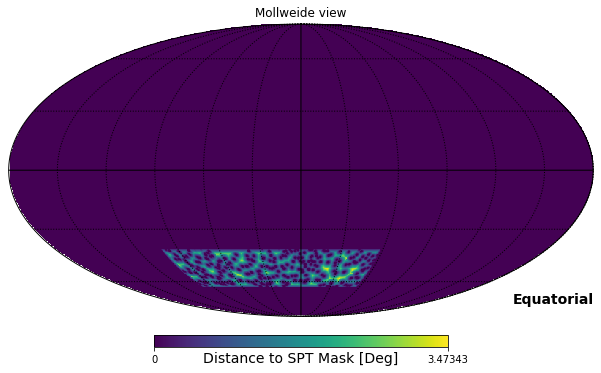

SPT-SZ Cluster Catalog Columns: 
 ['SPT_ID', 'RA', 'DEC', 'FIELD', 'XI', 'THETA_CORE', 'YSZ', 'DYSZ', 'REDSHIFT', 'REDSHIFT_UNC', 'REDSHIFT_LIMIT', 'XRAY', 'SPECZ', 'WEAK_LENSING', 'M500', 'M500_uerr', 'M500_lerr', 'M200', 'M200_uerr', 'M200_lerr', 'M500_marge', 'M500_marge_uerr', 'M500_marge_lerr', 'M200_marge', 'M200_marge_uerr', 'M200_marge_lerr']
--------------
Entire SPT-SZ Cluster Catalog (Bocquet et al. 2019) Size:  677
-------------- 

Number of SPT-SZ Clusters within a masked pixel (Chown 2018):  118
Number of SPT-SZ Clusters within 20 arcminutes of a masked pixel (Chown 2018):  206
-------------- 



In [2]:
## Comment this block out after first run through
## First time setup to generate the SPT-SZ mask distance map from smaller saved .npy files
divs = 20
spt_mask_distances = np.zeros(12*8192**2)  ## As the SPT HEALPix nside=8192
for d in range(divs):
    temp = np.load("./data/spt_mask_distances_map_subset%iof%i.npy"%(d+1, divs))
    ## Now assigning the distances in degrees (row 1) to their respective pixel index (row 0)
    spt_mask_distances[np.array(temp[0], dtype="int")] = temp[1]

## Test load and plot of the result
hp.mollview(spt_mask_distances, coord="C", unit="Distance to SPT Mask [Deg]")
hp.graticule()
plt.show()

## Example: Distances to nearest masked pixels for the SPT-SZ Cluster Catalog 
## (previously used in the stacking_example notebook)
catalog = Table.read("./data/2500d_cluster_sample_Bocquet19.fits", format="fits").to_pandas()
print("SPT-SZ Cluster Catalog Columns: \n", list(catalog.columns))
print("--------------")
print("Entire SPT-SZ Cluster Catalog (Bocquet et al. 2019) Size: ", len(catalog))
print("-------------- \n")
## Assign mask distances to each location (in degrees, and using interpolation)
catalog["SPT_mask_distance"] = hp.get_interp_val(spt_mask_distances, np.deg2rad(90-catalog["DEC"].values), np.deg2rad(catalog["RA"].values))

## See how many are within an SPT masked area:
print("Number of SPT-SZ Clusters within a masked pixel (Chown 2018): ", len(catalog[catalog["SPT_mask_distance"] == 0]))

## See how many are within 20 arcminutes of an SPT masked area:
print("Number of SPT-SZ Clusters within 20 arcminutes of a masked pixel (Chown 2018): ", len(catalog[catalog["SPT_mask_distance"] <= 20/60]))
## So not quite one third of the cluster catalog is within 20' of a masked pixel, 
## and thus may be influenced if stacked to that radius

## now to remove the mask_distance array from notebook memory just in case
spt_mask_distances = None; temp = None; catalog=None; del spt_mask_distances, temp, catalog
gc.collect()
print("-------------- \n")

## Map Processing Examples:
#### Processing SPT and ACT to be as similar as posible, while also subtracting the larger-scale Planck CMB (no-SZ) map
Showing how I take the original SPT and ACT maps (aka those used in the basic stacking_example notebook), and processed them to both have the:
* Same spherical multipole ell cutoff of 10,000 (the max of SPT, ACT starts with a max ell of 30,000).
* Same map projection (HEALPix Nside=8192, while correcting for pixel window functions).
* Same map beam function/resolution of 2.10 arcmin (FWHM), corresponding to the lowest resolution map (ACT 90GHz).
* Subtraction of the SMICA Planck CMB (no-SZ) map, to act as a large-scale high-pass filter of the CMB.

*Final files are saved as alm spherical harmonic coefficients, to both take up less space and avoid the excessive memory of healpy read/write processes.*

#### First the SPT maps, since they are easier due to already being in HEALPix format:

(50331648,)


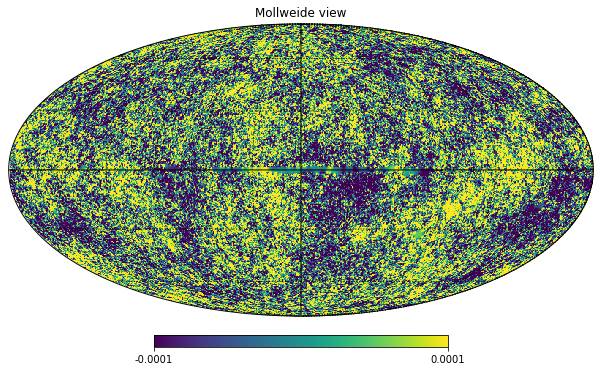

In [3]:
spt_lmax = 10000
final_nside = 8192
## Load the SMICA Planck CMB no-SZ map and rotate
smica_nside = 2048
smica_cmb = stacking.map_data_healpix_fits("./data/COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits", nside=smica_nside, 
                                           unreadable_header=False) ## Healpy seems to do fine with this file...
print(smica_cmb.shape)
## Map Checking (still in galactic coordinate/rotation)
hp.mollview(smica_cmb, max=1e-4, min=-1e-4)
hp.graticule()
plt.show()

(18877440,)
Rotated into celestial/equatorial (look for where center galaxy mask smoothing is now located): 


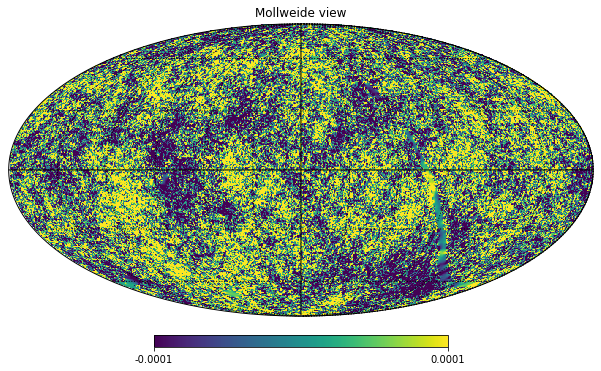

---------------


In [4]:
## Now convert it to alm

## Try the standard conversion: 
## (caution: ~30 seconds of high CPU usage for me). 
## I choose to use inter=5 instead of 3 just in case for better accuracy
smica_cmb_alm = hp.map2alm(smica_cmb, pol=False, use_pixel_weights=True, datapath="./data/", iter=5)
print(smica_cmb_alm.shape)

## Brief pause for CPU rest
time.sleep(5)

## Rotation
rot = hp.rotator.Rotator(coord=["G", "C"])
smica_cmb_alm = rot.rotate_alm(smica_cmb_alm)

## Save the SMICA rotated alm so it can just be loaded any subsequent tmes
hp.write_alm("./data/SMICAnoSZ_alm.fits", smica_cmb_alm, overwrite=True)

## Check... Note: hp.alm2map takes a few minutes, using all CPUs (though less intense for me than map2alm)
print("Rotated into celestial/equatorial (look for where center galaxy mask smoothing is now located): ")
smica_map = hp.alm2map(smica_cmb_alm, nside=smica_nside, pol=False)
hp.mollview(smica_map, max=1e-4, min=-1e-4)
hp.graticule()
plt.show()

## delete map version (in case of needing memory later on, 
## since smica_cmb_alm after rotation will be the starting point for both SPT and ACT).
smica_cmb = None; smica_map = None; del smica_cmb, smica_map
gc.collect()
print("---------------")

6144


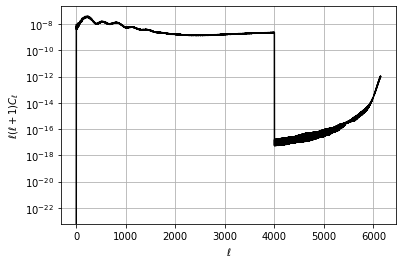

---------------


In [5]:
## Check the power spectrum
smica_cl = hp.alm2cl(smica_cmb_alm)
print(len(smica_cl))
ell = np.arange(len(smica_cl))
plt.plot(ell, ell * (ell+1)*smica_cl, marker="")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_{\ell}$")
plt.yscale("log")
plt.grid()
plt.show()
smica_cl = None; ell = None; del smica_cl, ell
gc.collect()
print("---------------")
## The higher ell values are noticeably lower, as expected for this 5 arcmin resolution map

In [6]:
## Now to remove & apply correct pixel window functions:
pixwin2048 = hp.pixwin(2048, pol=False, lmax=spt_lmax)
pixwin8192 = hp.pixwin(8192, pol=False, lmax=spt_lmax)
smica_cmb_alm_windowed = hp.almxfl(smica_cmb_alm, pixwin8192[:int(len(pixwin2048))]/pixwin2048)

## convert back to map for applying masks
smica_cmb_map_windowed = hp.alm2map(smica_cmb_alm_windowed, final_nside, pol=False)

## And... clean up everything no longer used (memory later is sparse...)
smica_cmb_alm = None; del smica_cmb_alm
smica_cmb_alm_windowed = None; del smica_cmb_alm_windowed
pixwin2048 = None; pixwin8192 = None; del pixwin2048, pixwin8192
gc.collect()
print("---------------")

---------------


#### Now to load the SPT masks (pt src and boundary mask).

In [7]:
## pt src first:
spt_pt_src_mask = stacking.map_data_healpix_fits("./data/mask_nside8192_ptsrc_50mJy.fits", unreadable_header=True)
## multiply mask:
smica_cmb_map_windowed *= spt_pt_src_mask
## clear memory of pt src mask:
spt_pt_src_mask = None; del spt_pt_src_mask
gc.collect()
print("---------------")

---------------


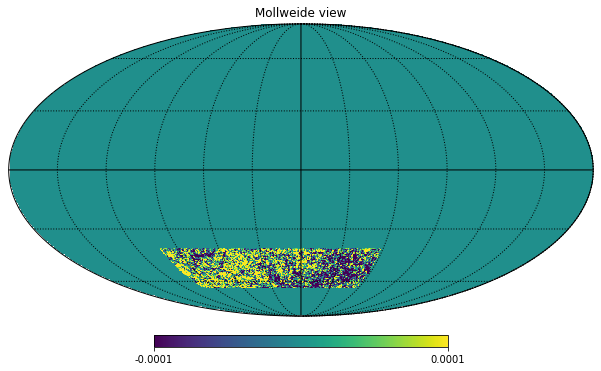

---------------


In [8]:
## Now boundary mask:
spt_boundary_mask = stacking.map_data_healpix_fits("./data/mask_nside8192_bdry.fits", unreadable_header=True)
## multiply mask:
smica_cmb_map_windowed *= spt_boundary_mask
## clear memory of pt src mask:
spt_boundary_mask = None; del spt_boundary_mask

## And plot the final map as a check:
hp.mollview(smica_cmb_map_windowed, max=1e-4, min=-1e-4)
hp.graticule()
plt.show()

gc.collect()
print("---------------")

In [9]:
## Now we turn it back into an alm (~ 1 minute of high CPU usage, using up all 16GB of memory):
smica_cmb_final_alm_spt = hp.map2alm(smica_cmb_map_windowed, lmax=spt_lmax, pol=False, use_pixel_weights=True, datapath="./data/", iter=5)
print(smica_cmb_final_alm_spt.shape)
smica_cmb_map_windowed = None; del smica_cmb_map_windowed
gc.collect()
print("---------------")

(50015001,)
---------------


SPT Frequency: 95GHz
(50015001,)


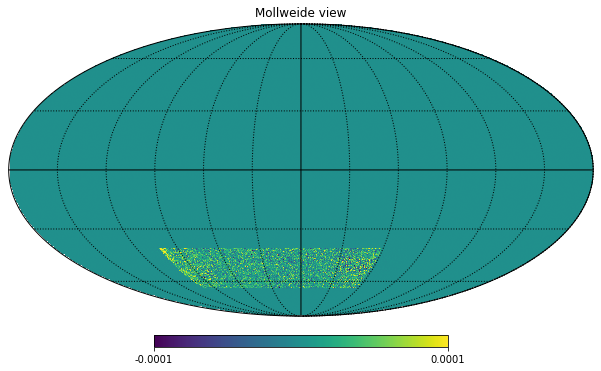

---------------
SPT Frequency: 150GHz
(50015001,)


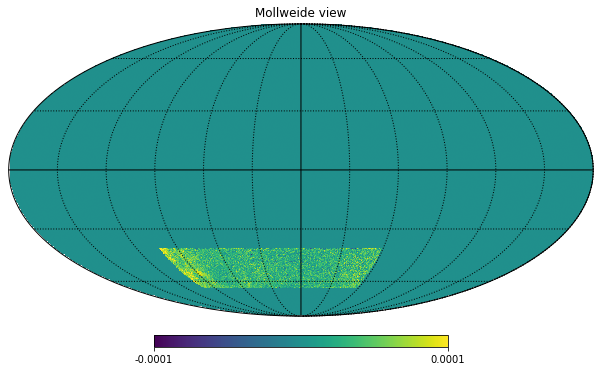

---------------
SPT Frequency: 220GHz
(50015001,)


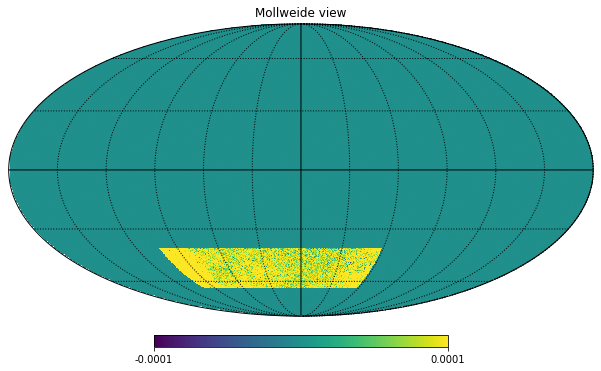

---------------


In [10]:
## Now for SPT alm processing, subtracting smica alm, and saving final alm:
beam2p10fwhm = hp.gauss_beam(np.deg2rad(2.10/60), lmax=spt_lmax, pol=False)
beam1p85fwhm = hp.gauss_beam(np.deg2rad(1.85/60), lmax=spt_lmax, pol=False)
spt_freqs = [95, 150, 220]

for f in spt_freqs:
    print("SPT Frequency: %iGHz"%f)
    ## Loading
    spt_alm = hp.read_alm("./data/alm_combined_data_%iGHz_ptsrcmasked_50mJy.fits"%f)
    print(spt_alm.shape)
    ## Smoothing to 2.10 FWHM [arcmin] (all SPT originally have 1.85 FHWM) and subtracting SMICA
    spt_alm = hp.almxfl(spt_alm, beam2p10fwhm/beam1p85fwhm) - smica_cmb_final_alm_spt
    gc.collect()
    
    ## Saving alm in its final form:
    hp.write_alm("./data/spt_%iGHz_minus_SMICAnoSZ_2.10fwhm_alm.fits"%f, spt_alm, overwrite=True)
    
    ## Test plotting:
    spt_map = hp.alm2map(spt_alm, nside=final_nside, pol=False)
    hp.mollview(spt_map, max=1e-4, min=-1e-4)
    hp.graticule()
    plt.show()
    
    ## Ensure memory stays low:
    spt_alm = None; spt_map = None; del spt_alm, spt_map
    gc.collect()
    print("---------------")
    ## Give the computer another short rest...
    time.sleep(5)

### Thus, the SPT maps have been processed...

The frequency maps shown above have noticeably fewer large-scale fluctuations, but smaller features and frequency-dependent signals (like dust) are still present.

##### *I will now switch over to the ACT maps to do a similar process, but differences arise from the Plate-Carree projection that they use...*

In [11]:
## We grab the existing SMICA alm from before (after G -> C rotation), now needing to convert it into 